# XGBoost Classification Model - Feature Importance by SHAP values



In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import shap

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from utils import get_training_dataset

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
# Read csv file and import to df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,1.018526,...,2.699781,5.762712,3445.709753,1,0.0,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,1.579400,...,4.585088,12.799127,8602.645832,1,0.0,0.00,1.00,0.000000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.551764,...,1.527495,8.833333,5084.012925,1,0.0,0.01,0.99,197.339034,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.107949,...,11.677657,17.530431,55607.865950,1,0.0,0.31,0.69,4970.477311,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,3.538881,...,17.074011,31.931338,35529.342507,1,0.0,0.77,0.23,12408.594656,0.0,0.0


In [4]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

In [5]:
# define a threshold to separate target into damaged and not_damaged
thres = 10.0

for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] >= thres:
        df.at[i, "binary_damage"] = 1
    else:
        df.at[i, "binary_damage"] = 0

df["binary_damage"] = df["binary_damage"].astype("int")

# Remove previous target 'percent_buildings_damaged' from the dataframe
df = df.drop(["percent_houses_damaged"], axis=1)
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,-0.213039,1.018526,...,2.699781,5.762712,3445.709753,1,0.00,0.000000,1.000000,0.000000,0.000000,0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,1.579400,...,4.585088,12.799127,8602.645832,1,0.00,0.000000,1.000000,0.000000,0.000000,0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.551764,...,1.527495,8.833333,5084.012925,1,0.00,0.010000,0.990000,197.339034,0.000000,0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.107949,...,11.677657,17.530431,55607.865950,1,0.00,0.310000,0.690000,4970.477311,0.000000,0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,3.538881,...,17.074011,31.931338,35529.342507,1,0.00,0.770000,0.230000,12408.594656,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,0.778646,4449.357133,0.508167,3.790141,...,18.012771,36.304688,21559.003490,1,0.08,0.080000,0.840000,17619.701390,0.000000,0
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,0.861458,1521.435795,-0.174100,3.532580,...,13.163042,65.687266,12591.742022,1,0.00,0.420000,0.580000,5623.069564,0.000000,0
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,4.444498,...,10.901755,37.414996,19740.596834,1,0.00,0.109091,0.890909,5912.671746,0.015207,0
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,5.816195,...,17.917650,105.812452,26363.303778,1,0.03,0.250000,0.720000,11254.164413,0.020806,0


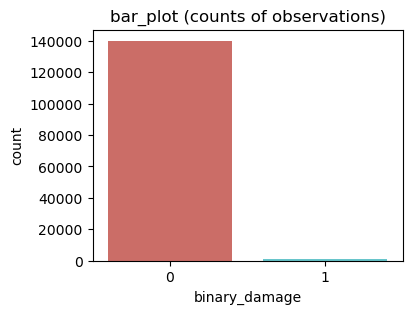

In [6]:
plt.figure(figsize=(4, 3))
sns.countplot(x="binary_damage", data=df, palette="hls")
plt.title("bar_plot (counts of observations)")
plt.show()

In [7]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage
138,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,12.896581,7.450346,74.625539,34.629550,42.218750,5303.659490,1,0.00,0.00,1.00,0.000000,0.0,0
139,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,14.070741,6.514647,68.681417,25.475388,72.283154,61015.543599,1,0.00,0.14,0.86,276.871504,0.0,0
148,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,19.758682,10.940700,104.453163,54.353996,102.215198,66707.438070,1,0.00,0.11,0.89,448.539453,0.0,0
149,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,11.499097,6.901584,59.798108,31.814048,58.988877,53841.050168,1,0.00,0.12,0.88,2101.708435,0.0,0
150,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,13.866633,6.528689,65.655280,25.976413,111.386527,87378.257957,1,0.07,0.46,0.47,11632.726327,0.0,0


array([[<AxesSubplot:title={'center':'binary_damage'}>]], dtype=object)

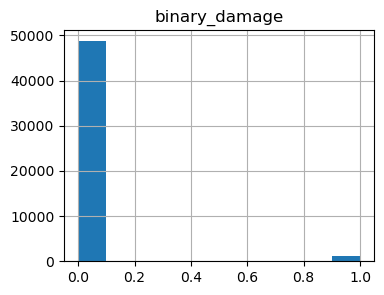

In [8]:
# Show histogram of damage
df.hist(column="binary_damage", figsize=(4, 3))

In [9]:
# Define bins and data stratification
bins2 = [0, 0.1, 1]
samples_per_bin2, binsP2 = np.histogram(df["binary_damage"], bins=bins2)

In [10]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["binary_damage"].value_counts(bins=binsP2)

(-0.001, 0.1]    48685
(0.1, 1.0]        1069
Name: binary_damage, dtype: int64

In [11]:
print(samples_per_bin2)
print(binsP2)

[48685  1069]
[0.  0.1 1. ]


In [12]:
bin_index2 = np.digitize(df["binary_damage"], bins=binsP2)

In [13]:
y_input_strat = bin_index2

In [14]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["binary_damage"]

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df["binary_damage"], stratify=y_input_strat, test_size=0.2
)

In [16]:
# Use XGBClassifier as a Machine Learning model to fit the data
xgb_model = XGBClassifier()

eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_set = [(X_test, y_test)]
xgb_model.fit(
    X_train,
    y_train,
    eval_metric=["error", "logloss"],
    eval_set=eval_set,
    verbose=False,
)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
# Make prediction on test data
y_pred = xgb_model.predict(X_test)

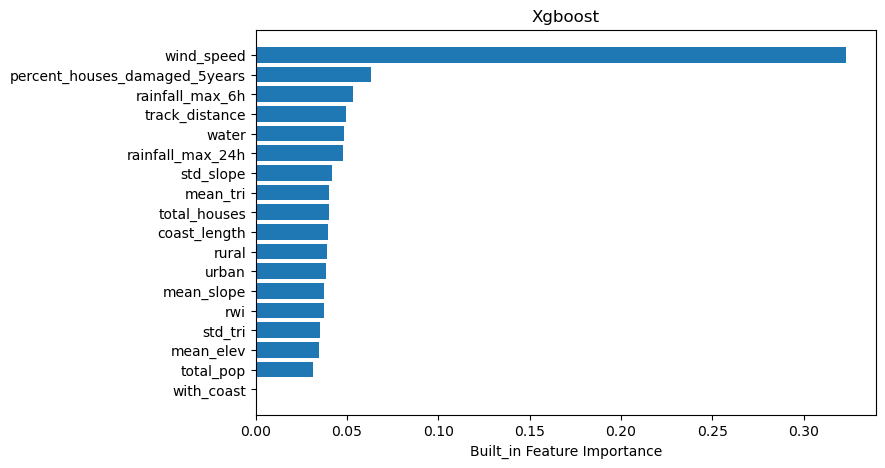

In [21]:
# Xgboost Built-in Feature Importance
plt.rcParams.update({"figure.figsize": (8.0, 5.0)})
plt.rcParams.update({"font.size": 10})

sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Built_in Feature Importance")
plt.title("Xgboost")
plt.show()

In [22]:
# Xgboost Feature Importance based on SHAP values
X_train4shapely = pd.DataFrame(data=X_train, columns=features)

In [23]:
explainer_xgb = shap.Explainer(xgb_model, X_train4shapely)
shap_values_xgb = explainer_xgb(X_train4shapely)

 99%|===================| 39553/39803 [01:18<00:00]        

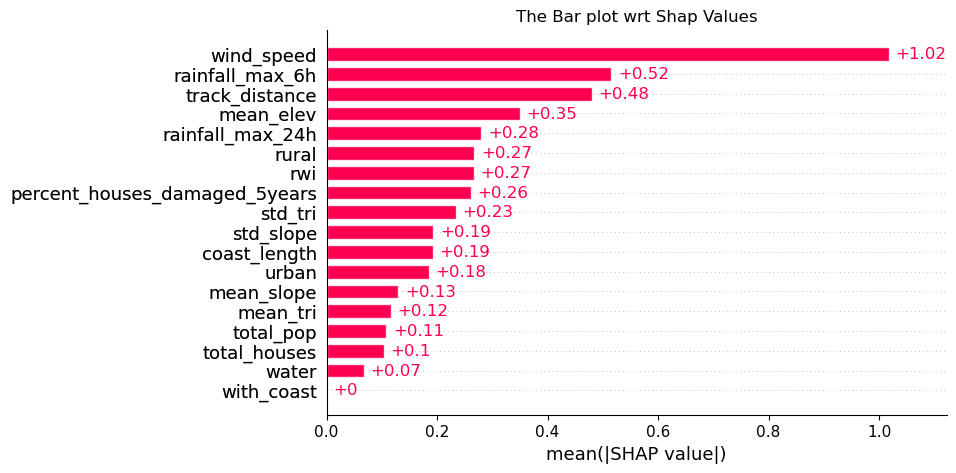

In [25]:
# Showing Barplot
plt.title("The Bar plot wrt Shap Values")
shap.plots.bar(shap_values_xgb, max_display=30, show=False)
plt.gcf().set_size_inches(8, 5)
plt.show()

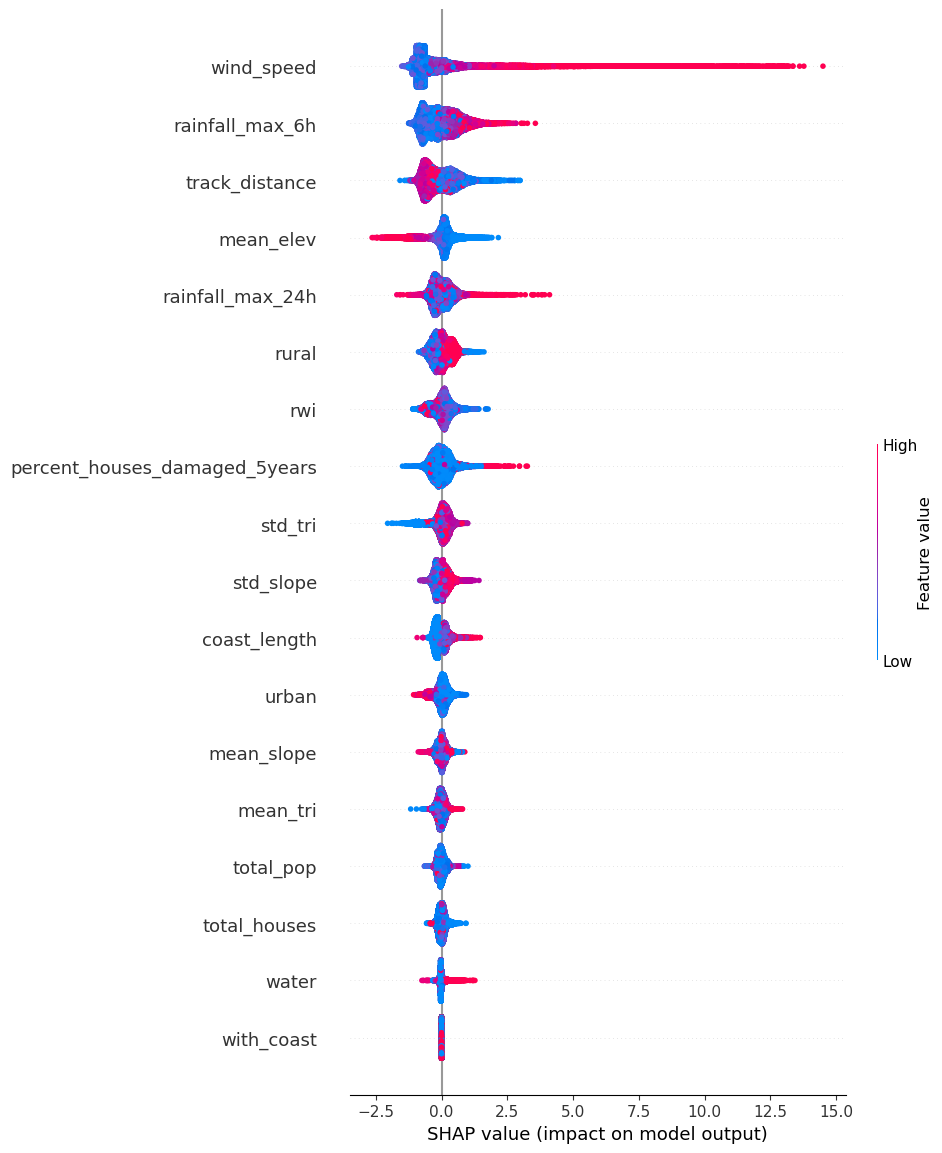

In [35]:
# Showing Beeswarm Plot
# plt.gcf().set_size_inches(4, 3)
shap.plots.beeswarm(
    shap_values_xgb,
    max_display=30,
    plot_size=0.7,
    # order=shap_values_xgb.abs.max(0)#, color="shap_red"
)